# Imports

In [9]:
%matplotlib inline

import numpy as np
import model_flux_ratio as mfr

from astropy.table import Table
from matplotlib import pyplot as plt

# Hydrogen C/R(lambda); assuming missing factor of 1e4

## xi, waves, temp

In [3]:
waves = np.array([4102.891, 4341.684, 4862.721, 6564.612])
temp = np.arange(10000, 25000)
xi = 1e-4 # xi*10^4 = 1; log(xi) = -4
xi2 = 1   # xi*10^4 = 4; log(xi) = 0

print (xi, xi2)

0.0001 1


In [42]:
pg = mfr.hydrogen_collision_to_recomb(xi, waves[1], temp) * np.exp( (-13.6*(-19/150)) / (8.6173303e-5*temp) )
h8 = mfr.hydrogen_collision_to_recomb(xi, waves[1], temp) * np.exp((-13.6 * ((1/5**2) - (1/8**2))) / (8.6173303e-5 * temp))
hd = mfr.hydrogen_collision_to_recomb(xi, waves[0], temp)
hg = mfr.hydrogen_collision_to_recomb(xi, waves[1], temp)
hb = mfr.hydrogen_collision_to_recomb(xi, waves[2], temp)
ha = mfr.hydrogen_collision_to_recomb(xi, waves[3], temp)

pg2 = mfr.hydrogen_collision_to_recomb(xi2, waves[1], temp) * np.exp( (-13.6*(-19/150)) / (8.6173303e-5*temp) )
h82 = mfr.hydrogen_collision_to_recomb(xi2, waves[1], temp) * np.exp((-13.6 * ((1/5**2) - (1/8**2))) / (8.6173303e-5 * temp))
hd2 = mfr.hydrogen_collision_to_recomb(xi2, waves[0], temp)
hg2 = mfr.hydrogen_collision_to_recomb(xi2, waves[1], temp)
hb2 = mfr.hydrogen_collision_to_recomb(xi2, waves[2], temp)
ha2 = mfr.hydrogen_collision_to_recomb(xi2, waves[3], temp)

### xi = 1e-4

/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


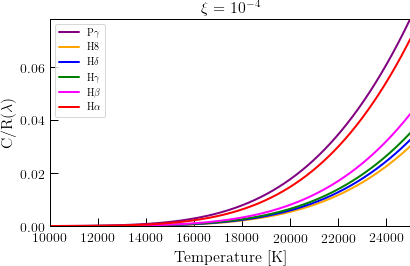

In [51]:
plt.plot(temp, pg, color='purple', label=r'P$\gamma$')
plt.plot(temp, h8, color='orange', label='H8')
plt.plot(temp, hd, color='blue', label=r'H$\delta$')
plt.plot(temp, hg, color='green', label=r'H$\gamma$')
plt.plot(temp, hb, color='magenta', label=r'H$\beta$')
plt.plot(temp, ha, color='red', label=r'H$\alpha$')
plt.xlabel('Temperature [K]')
plt.ylabel(r'C/R($\lambda$)')
plt.title(r'$\xi=10^{-4}$')
plt.legend()
plt.savefig('/Users/thsyu/Software/Yp/test_data/synthetic/CR.pdf')
plt.show()

### xi = 1

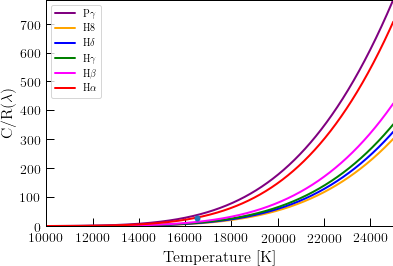

In [45]:
plt.plot(temp, pg2, color='purple', label=r'P$\gamma$')
plt.plot(temp, h82, color='orange', label='H8')
plt.plot(temp, hd2, color='blue', label=r'H$\delta$')
plt.plot(temp, hg2, color='green', label=r'H$\gamma$')
plt.plot(temp, hb2, color='magenta', label=r'H$\beta$')
plt.plot(temp, ha2, color='red', label=r'H$\alpha$')
plt.plot(16500, mfr.hydrogen_collision_to_recomb(xi2, waves[3], 16500), 'o')
#plt.ylim(-0.01, 0.08)
plt.xlabel('Temperature [K]')
plt.ylabel(r'C/R($\lambda$)')
plt.legend()
plt.show()

# Testing C/R, scaled for H8 and Pgamma

In [10]:
hydrogen_lines = np.array([10941.082, 6564.612, 4862.721, 4341.684, 4102.891, 3890.166])
hydrogen_CR_coeff = Table.read('/Users/thsyu/Software/Yp/tables/hydrogen_CR_coeff', format='ascii', delimiter='\t')

In [11]:
def hydrogen_collision_to_recomb(xi, wave, temp):
    '''
    Calculate the factor that corrects the
    measured hydrogen flux for emission due
    to collisional excitation of neutral
    hydrogen

    Assumes that at these densities
    and temperatures, all neutral hydrogen is
    excited from the ground state

    Parameters
    ----------
    xi : float
        n(HI)/n(HII); ratio of neutral hydrogen
        to ionized hydrogen densities
    wave : float
        Wavelength of the Balmer line (in Angstroms)
    temp : float
        Temperature of the gas (in Kelvin)

    Returns
    -------
    hydrogen_CR : float
        Relative amount of collisional to
        recombination emission for a given
        Balmer line
        C/R(wavelength) = eta*K_eff/alpha_eff
    '''
    # Redefine the temperature
    T4 = temp / 10000.

    # Match Balmer line of interest to relevant rows in Table 3 of AOS 2010
    idx = np.where(np.abs(hydrogen_lines - wave) < 3.5)[0][0]

    if idx == 1:
        line = str('Ha')
    elif idx == 2:
        line = str('Hb')
    elif idx == 3:
        line = str('Hg')
    elif idx == 4:
        line = str('Hd')
    #    print ('Hydrogen C/R for', line)

    rows = np.where(line == hydrogen_CR_coeff['Line'])[0]

    # Calculate the total K_eff/alpha_eff for relevant energy levels -- collisional sum includes an infinite
    # number of levels, but probabilities fall off quickly. This sum excludes terms contributing < 1%
    Keff_alphaeff = 0.
    for i in range(1, 9): # 1-9 here is to grab the 'Term1', 'Term2', etc. column names
        a, b, c = hydrogen_CR_coeff['Term ' + str(i)][rows]
        Keff_alphaeff += (a * np.exp(b/ T4) * (T4 ** c))

    # Amount of collisional to recombination emission; from Equation 6.1 of AOS 2010
    hydrogen_CR = Keff_alphaeff * xi * 1e4

    return hydrogen_CR

In [40]:
# H-delta, using scaling factor vs using Table data
print (hydrogen_collision_to_recomb(1e-2, hydrogen_lines[3], 18000) * np.exp((-13.6 * ((1/5**2) - (1/6**2))) / (8.6173303e-5 * 18000)))
print (hydrogen_collision_to_recomb(1e-2, hydrogen_lines[4], 18000))

0.23270866057204165
0.23308296874328974


In [48]:
# What are the correctional factors, given Eq. 6.4 from AOS2010?
print (np.exp((-13.6 * ((1/5**2) - (1/6**2))) / (8.6173303e-5 * 18000))) # H-delta
print (np.exp((-13.6 * ((1/5**2) - (1/8**2))) / (8.6173303e-5 * 18000))) # H8
print (np.exp((-13.6 * (((1/5**2) - (1/2**2)) - ((1/6**2)-(1/3**2)))) / (8.6173303e-5 * 18000))) # P-gamma

0.8983794521801567
0.8075772074333424
3.0361666389391893


In [49]:
print (-15.15/-15.34)

0.9876140808344198
